<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Publish-visualization" data-toc-modified-id="Publish-visualization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Publish visualization</a></span></li><li><span><a href="#Check-with-UDPIPE" data-toc-modified-id="Check-with-UDPIPE-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check with UDPIPE</a></span></li></ul></div>

# Imports

In [1]:
#TODO clean unneeded imports
import pandas as pd
import numpy as np
from nltk import word_tokenize
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.linear_model import LogisticRegression, LinearRegression, Lars, RidgeCV
#from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score

from tqdm import tnrange, tqdm_notebook
from time import sleep
import gc

from matplotlib import pyplot as plt
import os

from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

In [2]:
def save_obj(obj, name):
    pickle.dump(obj,open(name + '.pkl', 'wb'), protocol=4)
    
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Load data

In [2]:
files=os.listdir('DS_lemm/')
files=[f for f in files if '.txt' in f]
files

['lemmatization-cy.txt',
 'lemmatization-fr.txt',
 'lemmatization-ro.txt',
 'lemmatization-cs.txt',
 'lemmatization-tr.txt',
 'lemmatization-it.txt',
 'lemmatization-pt.txt',
 'lemmatization-es.txt',
 'lemmatization-ru.txt',
 'lemmatization-bg.txt',
 'lemmatization-sk.txt',
 'lemmatization-gd.txt',
 'lemmatization-hu.txt',
 'lemmatization-sl.txt',
 'lemmatization-et.txt',
 'lemmatization-ca.txt',
 'lemmatization-sv.txt',
 'lemmatization-gl.txt',
 'lemmatization-gv.txt',
 'lemmatization-uk.txt',
 'lemmatization-en.txt',
 'lemmatization-fa.txt',
 'lemmatization-de.txt',
 'lemmatization-ast.txt',
 'lemmatization-ga.txt']

In [3]:
len(files)

25

In [6]:
def get_lang(lang_code):
    ds=pd.read_csv('lang_codes_dic.csv',';')
    try:
        return ds[ds.Code==lang_code].iloc[0,1]
    except:
        return 'Undefined'


#vec encoding of words
def alpha_vec2(w, mx, max_word_len, dic):
    vec=np.zeros((max_word_len,len(dic)))    
    for i in range(0, len(w)):
        #print(i,w[i])
        vec[i]=mx[dic.index(w[i])]
        
    vec=vec.astype('float16').flatten()
    vec[vec==np.inf]=0 
    vec[vec==-np.inf]=0        
    return vec



#ordinal encoding of words
def alpha_vec2ord(w, max_word_len):
    vec=np.zeros(max_word_len)    
    for i in range(0, len(w)):        
        vec[i]=ord(w[i])    
    return vec.astype('int')

#ordinal decoding of words
def decode_vec(vec):
    w=''.join([chr(int(v)) for v in vec if v!=0])    
    return w.strip()

def lemm_model(dictionary_file):
    #load data
    lex = pd.read_csv('DS_lemm/'+ dictionary_file,'\t', encoding='utf8', names=['Lemma','Word_form'], keep_default_na=False)
    lang_code=dictionary_file[dictionary_file.index('-')+1:-4]
    lang=get_lang(lang_code)
    print('Language: ', lang, lang_code)
    number_words=lex.shape[0]
    
    X_lex=lex['Word_form'].str.strip()
    X_lex=X_lex.values
    
    Y_lex=lex['Lemma'].str.strip()
    Y_lex=Y_lex.values
    
    X_train, X_test, y_train, y_test = train_test_split(X_lex, Y_lex, test_size=0.1, random_state=42)
    
    #get max word length
    max_word_len=max(max([len(w) for w in Y_lex]),max([len(w) for w in X_lex]))
    
    #Char2vec model
    vectorizer = TfidfVectorizer(lowercase=False, analyzer='char')
    X = vectorizer.fit_transform(X_lex)
    dic=vectorizer.get_feature_names()#letter dictionary
    num_letters=len(dic)
    mx=X.T.dot(X)#letter cooccurence matrix
    mx=mx.toarray()
    
    #Vectorize
    X_lex_vec_train=[alpha_vec2(w, mx, max_word_len, dic) for w in X_train]
    Y_lex_vec_train=[alpha_vec2ord(w, max_word_len) for w in y_train]
    
    X_lex_vec_test=[alpha_vec2(w, mx, max_word_len, dic) for w in X_test]
    Y_lex_vec_test=[alpha_vec2ord(w, max_word_len) for w in y_test]
    
    #Build model
    best_model=ExtraTreesClassifier(n_estimators=10, n_jobs=5, criterion='entropy', bootstrap=True)
    
    best_model.fit(X_lex_vec_train, Y_lex_vec_train)
    
    #Test
    predicts_test=best_model.predict(X_lex_vec_test)
    predicts_train=best_model.predict(X_lex_vec_train)
    test_acc=sum([sum(p==y)==max_word_len for p,y in zip(predicts_test, Y_lex_vec_test)])/len(predicts_test)
    train_acc=sum([sum(p==y)==max_word_len for p,y in zip(predicts_train, Y_lex_vec_train)])/len(predicts_train)
    
    #Return results
    return test_acc, train_acc, max_word_len, num_letters, number_words, lang, lang_code, X_test, y_test

In [81]:
lemm_model('lemmatization-tr.txt')

Language:  Turkish tr


(0.9621795350923088, 0.9995739584821295, 50, 33, 1337898, 'Turkish', 'tr')

In [7]:
results=[]
xtests=[]
ytests=[]
langs=[]
for f in tqdm_notebook(files):
    test_acc, train_acc, max_word_len, num_letters, number_words, lang, lang_code, xtest, ytest=lemm_model(f)
    print(test_acc, train_acc, max_word_len, num_letters, number_words, lang, lang_code)
    results.append([test_acc, train_acc, max_word_len, num_letters, number_words, lang, lang_code])
    xtests.append(xtest)
    ytests.append(ytest)
    langs.append([lang, lang_code])

Language:  Welsh cy
0.8737299223338808 0.96423766087949 23 48 359224 Welsh cy
Language:  French fr
0.8111607142857142 0.9612299664184842 26 63 223999 French fr
Language:  Romanian ro
0.7859343731139418 0.965700651892323 53 63 314810 Romanian ro
Language:  Czech cs
0.46703296703296704 0.9423382173382173 26 79 36400 Czech cs
Language:  Turkish tr
0.9535167052844009 0.9966307009005837 50 33 1337898 Turkish tr
Language:  Italian it
0.9079394863375161 0.9755999035723826 29 34 341074 Italian it
Language:  Portuguese pt
0.8624084114457761 0.9668873826017299 26 50 850264 Portuguese pt
Language:  Spanish es
0.8663914619412002 0.9836999447341983 32 49 496591 Spanish es
Language:  Russian ru
0.7914858869526279 0.9101028088142388 27 34 2657468 Russian ru
Language:  Bulgarian bg
0.47642598087701943 0.9173323561744229 28 47 30323 Bulgarian bg
Language:  Slovak sk
0.9183150439178956 0.9858213862267854 29 78 858414 Slovak sk
Language:  Undefined gd
0.45322486926205696 0.9317061621575085 20 33 51624 Un

In [11]:
save_obj(xtests, 'xtests')
save_obj(ytests, 'ytests')
save_obj(langs, 'langs')

In [3]:
xtests=load_obj('xtests')
ytests=load_obj('ytests')
langs=load_obj('langs')

In [12]:
results_ds=pd.DataFrame(results, 
                        columns=['test_acc', 'train_acc', 'max_word_len', 'num_letters', 'number_words', 'lang', 'lang_code'])
results_ds.head()

,test_acc,train_acc,max_word_len,num_letters,number_words,lang,lang_code
0,0.873730,0.964238,23,48,359224,Welsh,cy
1,0.811161,0.961230,26,63,223999,French,fr
2,0.785934,0.965701,53,63,314810,Romanian,ro
3,0.467033,0.942338,26,79,36400,Czech,cs
4,0.953517,0.996631,50,33,1337898,Turkish,tr


In [13]:
results_ds.to_csv('results_ds.csv', ';', index=False)

In [14]:
results_ds.describe()

,test_acc,train_acc,max_word_len,num_letters,number_words
count,25.000000,25.000000,25.000000,25.00000,2.500000e+01
mean,0.715304,0.960891,28.680000,55.00000,4.251473e+05
std,0.197316,0.027464,8.137977,15.47848,5.691397e+05
min,0.377389,0.895615,18.000000,33.00000,6.273000e+03
25%,0.476426,0.942338,23.000000,44.00000,6.717700e+04
50%,0.785934,0.971260,26.000000,54.00000,3.148100e+05
75%,0.885201,0.979871,31.000000,66.00000,4.965910e+05
max,0.953517,0.996631,53.000000,85.00000,2.657468e+06


In [15]:
results_ds.iloc[:,:5].corr()

,test_acc,train_acc,max_word_len,num_letters,number_words
test_acc,1.000000,0.641023,0.284822,-0.032314,0.491264
train_acc,0.641023,1.000000,0.047900,0.095991,-0.008822
max_word_len,0.284822,0.047900,1.000000,0.110813,0.214865
num_letters,-0.032314,0.095991,0.110813,1.000000,-0.282869
number_words,0.491264,-0.008822,0.214865,-0.282869,1.000000


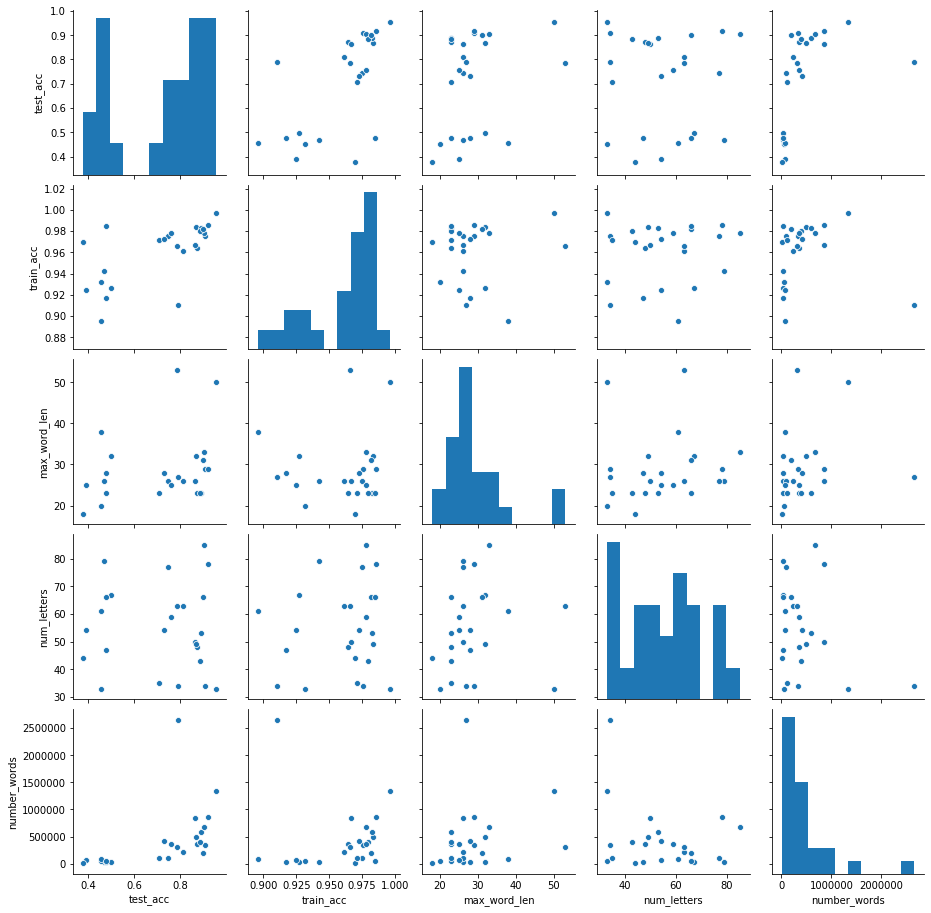

In [16]:
import seaborn as sns
sns.pairplot(results_ds)

In [ ]:
import plotly.express as px

fig = px.scatter(results_ds, x="number_words", y="test_acc", color="lang_code",
                 size='max_word_len', hover_data=['lang'])#[results_ds.number_words>300000]
fig.show()

# Publish visualization

In [25]:
import chart_studio

In [26]:
username = 'XXXXXXXXXX' # your username
api_key = 'YYYYYYYYY' # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [27]:
import chart_studio.plotly as py
py.plot(fig, filename = 'lemmatization', auto_open=True)

'https://plotly.com/~isa_almaty/8/'

# Check with UDPIPE

In [4]:
import requests
import json

def get_udpipe_lemm(lang_code, word):
    response = requests.get('http://lindat.mff.cuni.cz/services/udpipe/api/process?model='+lang_code+'&tokenizer&tagger&parser&data='+word)
    y = json.loads(response.text)
    return y["result"].split('\n')[4].split('\t')[2]

In [41]:
get_udpipe_lemm('tr', 'Internet')

'Internet'

In [5]:
langs

[['Welsh', 'cy'],
 ['French', 'fr'],
 ['Romanian', 'ro'],
 ['Czech', 'cs'],
 ['Turkish', 'tr'],
 ['Italian', 'it'],
 ['Portuguese', 'pt'],
 ['Spanish', 'es'],
 ['Russian', 'ru'],
 ['Bulgarian', 'bg'],
 ['Slovak', 'sk'],
 ['Undefined', 'gd'],
 ['Hungarian', 'hu'],
 ['Slovenian', 'sl'],
 ['Estonian', 'et'],
 ['Catalan', 'ca'],
 ['Swedish', 'sv'],
 ['Galician', 'gl'],
 ['Undefined', 'gv'],
 ['Ukrainian', 'uk'],
 ['English', 'en'],
 ['Farsi', 'fa'],
 ['German', 'de'],
 ['Undefined', 'ast'],
 ['Undefined', 'ga']]

In [6]:

proceed=True
for l,x,y in zip(tqdm_notebook(langs, desc='languages'),xtests,ytests):
    try:
        #if l==['Bulgarian', 'bg']:
        #proceed=True
            
        if proceed:
            print(l, get_udpipe_lemm(l[1], 'Internet'))

            udpipe_ytest=[]
            corr_count=0
            for w,lemm in zip(tqdm_notebook(x, desc='words'),y):
                try:
                    udpipe_lemm=get_udpipe_lemm(l[1], w)
                    udpipe_ytest.append(udpipe_lemm)
                    if udpipe_lemm==lemm:
                        corr_count+=1
                except:
                    udpipe_ytest.append('UNK')
                    continue
            acc=corr_count/len(y)
            print('UDPIPE accuracy',acc)
            
            #write accuracy results to csv
            f=open('UDPipe_acc_res.csv','a', encoding='utf8')
            f.write(l[0]+';'+l[1]+';'+str(acc)+'\n')
            f.close()
            
            #save UDPipe answers
            save_obj(udpipe_ytest,'udpipe_ytests_'+l[1])
            
            
    except:
        continue

['French', 'fr'] Internet



UDPIPE accuracy 0.5008035714285715
['Romanian', 'ro'] internet



UDPIPE accuracy 0.41450398653155873
['Czech', 'cs'] internet



UDPIPE accuracy 0.7752747252747253
['Turkish', 'tr'] Internet



UDPIPE accuracy 0.29177068540249645
['Italian', 'it'] Internet



UDPIPE accuracy 0.4366424299284625
['Portuguese', 'pt'] _



UDPIPE accuracy 0.38898232326202264
['Spanish', 'es'] internet



UDPIPE accuracy 0.5197341925090616
['Russian', 'ru'] internet



UDPIPE accuracy 0.5148505909756272
['Bulgarian', 'bg'] Internet



UDPIPE accuracy 0.4807121661721068
['Slovak', 'sk'] internet



UDPIPE accuracy 0.3636797837888213
['Undefined', 'gd'] Internet



UDPIPE accuracy 0.14894441216347085
['Hungarian', 'hu'] Internet



UDPIPE accuracy 0.5979949874686716
['Slovenian', 'sl'] internet



UDPIPE accuracy 0.6776016957706672
['Estonian', 'et'] internet



UDPIPE accuracy 0.6272659548050658
['Catalan', 'ca'] Internet



UDPIPE accuracy 0.384301991412246
['Swedish', 'sv'] Intern



UDPIPE accuracy 0.4882394762567764
['Galician', 'gl'] internet



UDPIPE accuracy 0.5190653158886117
['Ukrainian', 'uk'] Internet



UDPIPE accuracy 0.6086934076712611
['English', 'en'] internet



UDPIPE accuracy 0.7337334933973589
['Farsi', 'fa'] Internet



UDPIPE accuracy 0.39171974522292996
['German', 'de'] Internet



UDPIPE accuracy 0.30551216246373575
['Undefined', 'ga'] Internet



UDPIPE accuracy 0.16399123968135546

